<a href="https://colab.research.google.com/github/kapoor1309/Segmentation-using-wsl/blob/main/WSLSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Kaggle if not installed
!pip install -q kaggle

# Upload kaggle.json (Download from your Kaggle account)
from google.colab import files
files.upload()  # Manually upload kaggle.json when prompted

# Move kaggle.json to the correct directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Extract the dataset
import zipfile
import os

dataset_path = "chest-xray-pneumonia.zip"
extracted_path = "chest_xray_data"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print("Dataset downloaded and extracted successfully.")


Saving kaggle (3).json to kaggle (3) (1).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset downloaded and extracted successfully.


In [2]:
import numpy as np
import pandas as pd
import cv2

extracted_folder = "/content/chest_xray_data"
# Define labels and image size
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150

# Define function to load and preprocess images
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # 0 - Normal, 1 - Pneumonia

        for img in os.listdir(path):
            # Skip non-image files
            if not img.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append((np.array(resized_arr), class_num))
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    return data

# Update dataset paths for Colab
base_path = os.path.join(extracted_folder, "chest_xray")

train = get_training_data(os.path.join(base_path, "train"))
test = get_training_data(os.path.join(base_path, "test"))
val = get_training_data(os.path.join(base_path, "val"))

print("Dataset loaded successfully.")

Dataset loaded successfully.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np

In [4]:
train[0]

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [1, 1, 1]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 0)

Text(0.5, 1.0, 'PNEUMONIA')

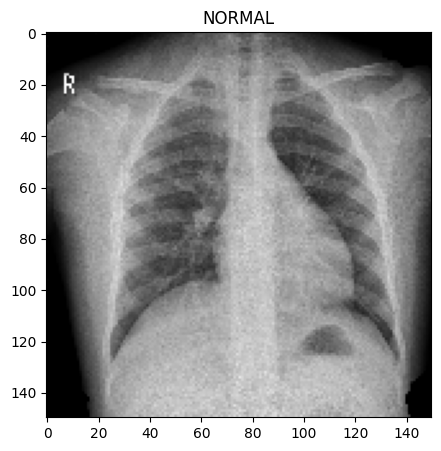

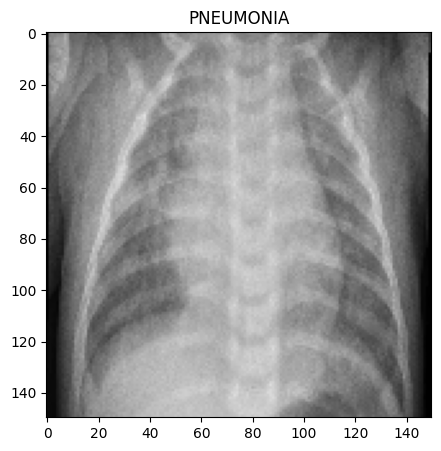

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

x_val = []
y_val = []

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [7]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [8]:
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [9]:
print("Training Data:")
print(f"x_train length: {len(x_train)}, x_train shape: {x_train.shape}")
print(f"y_train length: {len(y_train)}, y_train shape: {y_train.shape}")

print("\nValidation Data:")
print(f"x_val length: {len(x_val)}, x_val shape: {x_val.shape}")
print(f"y_val length: {len(y_val)}, y_val shape: {y_val.shape}")

print("\nTest Data:")
print(f"x_test length: {len(x_test)}, x_test shape: {x_test.shape}")
print(f"y_test length: {len(y_test)}, y_test shape: {y_test.shape}")


from sklearn.model_selection import train_test_split

# Merge train and validation data
x_train_combined = np.concatenate((x_train, x_val), axis=0)
y_train_combined = np.concatenate((y_train, y_val), axis=0)

# Perform an 80-20 split on the combined dataset
x_train, x_val, y_train, y_val = train_test_split(
    x_train_combined, y_train_combined, test_size=0.2, random_state=42, stratify=y_train_combined
)

# Print the new shapes
print("After Merging and Splitting:")
print("\nTraining Data:")
print(f"x_train length: {len(x_train)}, x_train shape: {x_train.shape}")
print(f"y_train length: {len(y_train)}, y_train shape: {y_train.shape}")

print("\nValidation Data:")
print(f"x_val length: {len(x_val)}, x_val shape: {x_val.shape}")
print(f"y_val length: {len(y_val)}, y_val shape: {y_val.shape}")

print("\nTest Data (Unchanged):")
print(f"x_test length: {len(x_test)}, x_test shape: {x_test.shape}")
print(f"y_test length: {len(y_test)}, y_test shape: {y_test.shape}")

del x_train_combined, y_train_combined


Training Data:
x_train length: 5216, x_train shape: (5216, 150, 150, 3)
y_train length: 5216, y_train shape: (5216,)

Validation Data:
x_val length: 16, x_val shape: (16, 150, 150, 3)
y_val length: 16, y_val shape: (16,)

Test Data:
x_test length: 624, x_test shape: (624, 150, 150, 3)
y_test length: 624, y_test shape: (624,)
After Merging and Splitting:

Training Data:
x_train length: 4185, x_train shape: (4185, 150, 150, 3)
y_train length: 4185, y_train shape: (4185,)

Validation Data:
x_val length: 1047, x_val shape: (1047, 150, 150, 3)
y_val length: 1047, y_val shape: (1047,)

Test Data (Unchanged):
x_test length: 624, x_test shape: (624, 150, 150, 3)
y_test length: 624, y_test shape: (624,)


In [10]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Flatten the image data to 2D (necessary for oversampling)
x_train_flat = x_train.reshape(x_train.shape[0], -1)  # Shape: (5216, 150*150*3)

# Oversample using RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train_flat, y_train)

# Reshape the oversampled data back to its original image dimensions
x_train_resampled = x_train_resampled.reshape(-1, 150, 150, 3)  # Shape: (new_len, 150, 150, 3)

unique, counts = np.unique(y_train_resampled, return_counts=True)
print("Class distribution after oversampling:", dict(zip(unique, counts)))

# Shuffle the oversampled dataset
from sklearn.utils import shuffle
x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=42)

Class distribution after oversampling: {0: 3106, 1: 3106}


In [11]:
x_train = x_train_resampled
y_train = y_train_resampled

del x_train_resampled, y_train_resampled

In [12]:
data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1  # randomly shift images vertically (fraction of total height)
        )


data_generator.fit(x_train)

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_attention_map(model, img, layer_name):
    # Ensure image values are between 0 and 255 and convert to uint8
    if img.max() <= 1.0:  # If normalized
        img = (img * 255).astype(np.uint8)

    # Generate attention map
    attention_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    attention_map = attention_model(np.expand_dims(img, axis=0)).numpy()[0]

    # Take the mean across all channels if multi-channel attention
    attention_map = np.mean(attention_map, axis=-1)

    # Normalize the attention map to 0-255
    attention_map -= attention_map.min()
    attention_map /= attention_map.max()
    attention_map = (attention_map * 255).astype(np.uint8)

    # Resize attention map to match the image size
    attention_map_resized = cv2.resize(attention_map, (img.shape[1], img.shape[0]))

    # Overlay attention map on the original image
    heatmap = cv2.applyColorMap(attention_map_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

    # Plot the results
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Attention Map
    plt.subplot(1, 3, 2)
    plt.imshow(attention_map_resized, cmap='jet')
    plt.title("Attention Map")
    plt.axis('off')

    # Superimposed Image
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Superimposed Image")
    plt.axis('off')

    plt.show()

In [14]:

def plot_training_curves(history, title_prefix=""):
    epochs = range(1, len(history.history['loss']) + 1)
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Misclassification Error (1 - accuracy)
    plt.subplot(1, 2, 2)
    train_error = [1 - acc for acc in history.history['accuracy']]
    val_error = [1 - acc for acc in history.history['val_accuracy']]
    plt.plot(epochs, train_error, 'bo-', label='Training Misclassification Error')
    plt.plot(epochs, val_error, 'ro-', label='Validation Misclassification Error')
    plt.title(f'{title_prefix} Misclassification Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
x_train_small = x_train[:]
y_train_small = y_train[:]
x_val_small = x_val[:]
y_val_small = y_val[:]

In [16]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import datetime  # For timestamped logs

# ====== Data Preparation ======
data_generator = ImageDataGenerator(rescale=1./255)
data_generator.fit(x_train_small)

# ====== TensorBoard Callback Setup ======
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ====== Model: ResNet50 ======
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
# Freeze the first 20% of the layers
freeze_upto = int(0.2 * len(base_resnet.layers))
for layer in base_resnet.layers[:freeze_upto]:
    layer.trainable = False

# Add custom classification layers
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_resnet = Model(inputs=base_resnet.input, outputs=predictions)
model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.summary()

# ====== Train the Model with TensorBoard ======
history_resnet = model_resnet.fit(
    data_generator.flow(x_train_small, y_train_small, batch_size=16),
    epochs=5,
    validation_data=(x_val_small, y_val_small),
    callbacks=[tensorboard_callback]  # ✅ Adding TensorBoard Callback
)

# ====== Evaluate the Model ======
preds_resnet = model_resnet.predict(x_test)
y_pred_resnet = (preds_resnet > 0.5).astype(int)
print("\nResNet Model Evaluation on Test Data:")
print(classification_report(y_test, y_pred_resnet, target_names=labels))

# ====== Start TensorBoard ======
# Run this in a separate Jupyter Notebook cell or terminal:
# ⬇️ Jupyter Notebook
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

# ⬇️ Command Line (if using terminal)
# tensorboard --logdir=logs/fit

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 23,587,329 (89.98 MB)

 Non-trainable params: 262,784 (1.00 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
389/389 ━━━━━━━━━━━━━━━━━━━━ 125s 193ms/step - accuracy: 0.4949 - loss: 0.7121 - val_accuracy: 0.2846 - val_loss: 0.7720
Epoch 2/5
389/389 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.4996 - loss: 0.6931 - val_accuracy: 0.2617 - val_loss: 0.7908
Epoch 3/5
389/389 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - accuracy: 0.5047 - loss: 0.6931 - val_accuracy: 0.2684 - val_loss: 0.7942
Epoch 4/5
389/389 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.5058 - loss: 0.6931 - val_accuracy: 0.2693 - val_loss: 0.7942
Epoch 5/5
389/389 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step - accuracy: 0.5068 - loss: 0.6931 - val_accuracy: 0.2693 - val_loss: 0.7940
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step

ResNet Model Evaluation on Test Data:
              precision    recall  f1-score   support

      NORMAL       0.37      0.96      0.54       234
   PNEUMONIA       0.47      0.02      0.04       390

    accuracy                           0.37       624
   macro avg       0.42      0.49      0.29       

In [20]:
# attention map visualization
example_image = x_test[0]
example_image2 = x_test[6]
plot_attention_map(model_resnet, example_image, layer_name="conv5_block3_out")
plot_attention_map(model_resnet, example_image2, layer_name="conv5_block3_out")
del model_resnet

NameError: name 'model_resnet' is not defined